In [1]:
#Mount the google drive:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
#Check the directory:
cd /content/drive/My Drive/Colab Notebooks/Six_Classes

/content/drive/My Drive/Colab Notebooks/Six_Classes


In [3]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet import preprocess_input, decode_predictions

Using TensorFlow backend.


In [0]:
WIDTH=224
HEIGHT=224
BATCH_SIZE=64
test_dir = 'test/'
train_dir = 'train/'
val_dir = 'val/'

In [5]:
#Train DataSet Generator with Augmentation
print("\nTraining Data Set")
train_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
train_flow = train_generator.flow_from_directory(
    train_dir,
    target_size=(HEIGHT, WIDTH),
    batch_size = BATCH_SIZE
)


Training Data Set
Found 11235 images belonging to 6 classes.


In [6]:
#Validation DataSet Generator with Augmentation
print("\nValidation Data Set")
val_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
val_flow = val_generator.flow_from_directory(
    val_dir,
    target_size=(HEIGHT, WIDTH),
    batch_size = BATCH_SIZE
)


Validation Data Set
Found 622 images belonging to 6 classes.


In [7]:
#Test DataSet Generator with Augmentation
print("\nTest Data Set")
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
test_flow = test_generator.flow_from_directory(
    test_dir,
    target_size=(HEIGHT, WIDTH),
    batch_size = BATCH_SIZE
)


Test Data Set
Found 1256 images belonging to 6 classes.


In [0]:
from keras.models import Sequential, Model, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, CSVLogger
from keras import optimizers, models
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras import applications
from keras import backend as K
import tensorflow as tf
import os

In [0]:
NUM_PARALLEL_EXEC_UNITS = 8

In [0]:
#Set Performance Parameters for MKL and Tensorflow using Keras backend
#TensorFlow
config = tf.ConfigProto(
    intra_op_parallelism_threads=NUM_PARALLEL_EXEC_UNITS,
    inter_op_parallelism_threads=1
)

In [0]:
session = tf.Session(config=config)
K.set_session(session)


In [0]:
#MKL and OpenMP
os.environ["OMP_NUM_THREADS"] = str(NUM_PARALLEL_EXEC_UNITS)
os.environ["KMP_BLOCKTIME"] = "1"
os.environ["KMP_SETTINGS"] = "1"
os.environ["KMP_AFFINITY"]= "granularity=fine,verbose,compact,1,0"

In [13]:
# Initialize mobilenet with transfer learning
base_model = applications.MobileNet(weights='imagenet', 
                                include_top=False, 
                                input_shape=(WIDTH, HEIGHT,3))











17227776/17225924 [==============================] - 1s 0us/step


In [0]:
# add a global spatial average pooling layer
x = base_model.output

In [0]:
x = GlobalAveragePooling2D()(x)
# and a dense layer
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(train_flow.class_indices), activation='softmax')(x)

In [0]:
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [0]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

In [18]:
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=optimizers.Adam(lr=0.001), metrics=['accuracy', 'top_k_categorical_accuracy'], loss='categorical_crossentropy')
model.summary()



Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      12

In [0]:
import math
top_layers_file_path="top_layers.mn.hdf5"


In [0]:
checkpoint = ModelCheckpoint(top_layers_file_path, monitor='loss', verbose=1, save_best_only=True, mode='min')
tb = TensorBoard(log_dir='./logs', batch_size=val_flow.batch_size, write_graph=True, update_freq='batch')
early = EarlyStopping(monitor="loss", mode="min", patience=5)
csv_logger = CSVLogger('./logs/mn-log.csv', append=True)

In [22]:
history = model.fit_generator(train_flow, 
                              epochs=3, 
                              verbose=1,
                              validation_data=val_flow,
                              validation_steps=math.ceil(val_flow.samples/val_flow.batch_size),
                              steps_per_epoch=math.ceil(train_flow.samples/train_flow.batch_size),
                              callbacks=[checkpoint, early, tb, csv_logger])

Epoch 1/3
176/176 [==============================] - 65s 369ms/step - loss: 0.0518 - acc: 0.9843 - top_k_categorical_accuracy: 1.0000 - val_loss: 1.1926 - val_acc: 0.5965 - val_top_k_categorical_accuracy: 0.9855

Epoch 00001: loss improved from 0.33142 to 0.05163, saving model to top_layers.mn.hdf5
Epoch 2/3
176/176 [==============================] - 64s 362ms/step - loss: 0.0496 - acc: 0.9838 - top_k_categorical_accuracy: 0.9999 - val_loss: 0.9246 - val_acc: 0.7186 - val_top_k_categorical_accuracy: 0.9871

Epoch 00002: loss improved from 0.05163 to 0.04967, saving model to top_layers.mn.hdf5
Epoch 3/3
176/176 [==============================] - 63s 357ms/step - loss: 0.0234 - acc: 0.9928 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.9338 - val_acc: 0.7251 - val_top_k_categorical_accuracy: 0.9936

Epoch 00003: loss improved from 0.04967 to 0.02343, saving model to top_layers.mn.hdf5


In [23]:
model.load_weights(top_layers_file_path)
loss, acc, top_5 = model.evaluate_generator(
    test_flow,
    verbose = True,
    steps=math.ceil(test_flow.samples/test_flow.batch_size))
print("Loss: ", loss)
print("Acc: ", acc)
print("Top 5: ", top_5)

20/20 [==============================] - 492s 25s/step
Loss:  1.3548380257977042
Acc:  0.6791401277681824
Top 5:  0.9976114657274477


In [0]:
label = [k for k,v in train_flow.class_indices.items()]
with open('mn-labels.txt', 'w+') as file:
    file.write("\n".join(label))

In [25]:
from keras.preprocessing import image
import numpy as np
import glob
import random

file_list = glob.glob("test/*/*")
img_path = random.choice(file_list)
img_cat = os.path.split(os.path.dirname(img_path))[1]
print("Image Category: ", img_cat)
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
print("Raw Predictions: ", preds)

top_x = 3
top_args = preds[0].argsort()[-top_x:][::-1]
preds_label = [label[p] for p in top_args]
print("\nTop " + str(top_x) + " confidence: " + " ".join(map(str, sorted(preds[0])[-top_x:][::-1])))
print("Top " + str(top_x) + " labels: " + " ".join(map(str, preds_label)))

Image Category:  Red_Deer
Raw Predictions:  [[6.9340802e-04 1.1363633e-05 1.0804304e-06 9.9020493e-01 5.6083937e-08
  9.0891048e-03]]

Top 3 confidence: 0.99020493 0.009089105 0.000693408
Top 3 labels: Red_Deer White-nosed_Coati Collared_Peccary


In [26]:
from tensorflow.python.framework import graph_util
from tensorflow.python.framework import graph_io

input_model_path = top_layers_file_path
output_model_name = "top_nodes.mn.pb"
output_model_dir = "tf_model"

K.set_learning_phase(0)
sess = K.get_session()

test_model = models.load_model(input_model_path)
orig_output_node_names = [node.op.name for node in test_model.outputs]

constant_graph = graph_util.convert_variables_to_constants(
    sess,
    sess.graph.as_graph_def(),
    orig_output_node_names)
graph_io.write_graph(
    constant_graph,
    output_model_dir,
    output_model_name,
    as_text=False)

Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 139 variables.
INFO:tensorflow:Converted 139 variables to const ops.


'tf_model/top_nodes.mn.pb'

In [0]:
from keras.models import load_model
model = load_model('top_layers.mn.hdf5')

In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet import preprocess_input

In [29]:
#Test DataSet Generator with Augmentation
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
test_flow = test_generator.flow_from_directory(
    'test',
    shuffle=False,
    target_size=(224, 224),
    batch_size = 32
)

Found 1256 images belonging to 6 classes.


In [30]:
import math
import numpy as np
predictions = model.predict_generator(
    test_flow,
    verbose=1,
    steps=math.ceil(test_flow.samples/test_flow.batch_size))
predicted_classes = np.argmax(predictions, axis=1) 

true_classes = test_flow.classes
class_labels = list(test_flow.class_indices.keys())  

40/40 [==============================] - 59s 1s/step


In [31]:
pip install scikit-plot

0 : Collared_Peccary
1 : European_Hare
2 : Ocelot
3 : Red_Deer
4 : Red_Squirrel
5 : White-nosed_Coati


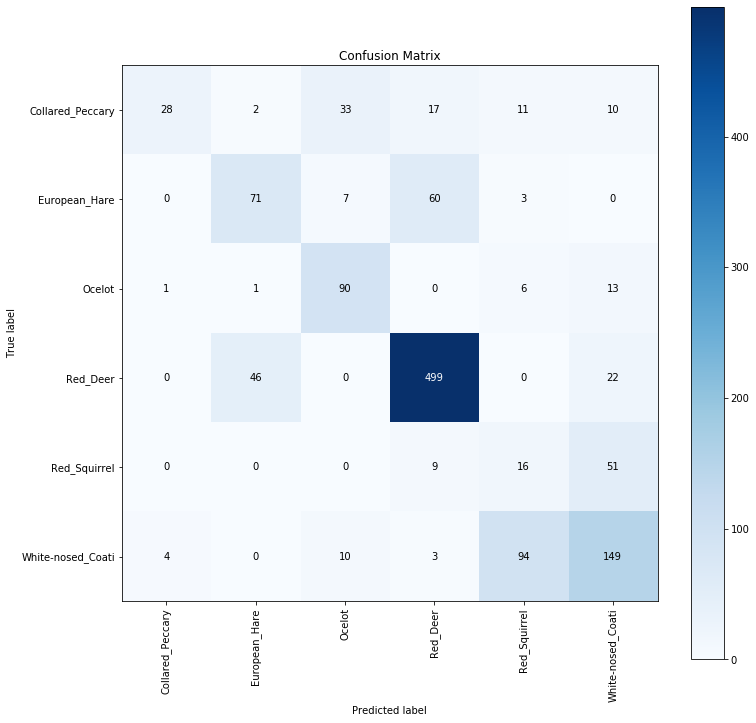

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline  
import scikitplot as skplt

[print(k, ":", v) for k,v in enumerate(class_labels)]
true_map_classes = [class_labels[x] for x in true_classes]
predicted_map_classes = [class_labels[x] for x in predicted_classes]

skplt.metrics.plot_confusion_matrix(
    true_map_classes, 
    predicted_map_classes,
    labels=class_labels,
    x_tick_rotation=90,
    figsize=(12,12))

In [33]:
from sklearn.metrics import classification_report
report = classification_report(
    true_classes,
    predicted_classes,
    target_names=class_labels)
print(report)

                   precision    recall  f1-score   support

 Collared_Peccary       0.85      0.28      0.42       101
    European_Hare       0.59      0.50      0.54       141
           Ocelot       0.64      0.81      0.72       111
         Red_Deer       0.85      0.88      0.86       567
     Red_Squirrel       0.12      0.21      0.16        76
White-nosed_Coati       0.61      0.57      0.59       260

         accuracy                           0.68      1256
        macro avg       0.61      0.54      0.55      1256
     weighted avg       0.71      0.68      0.68      1256



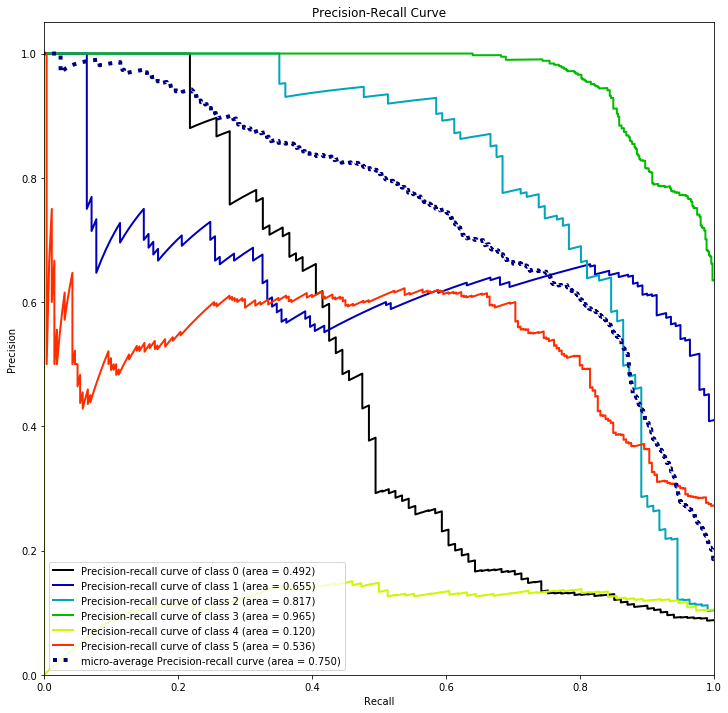

In [34]:
skplt.metrics.plot_precision_recall(
    true_classes,
    predictions,
    figsize=(12,12))

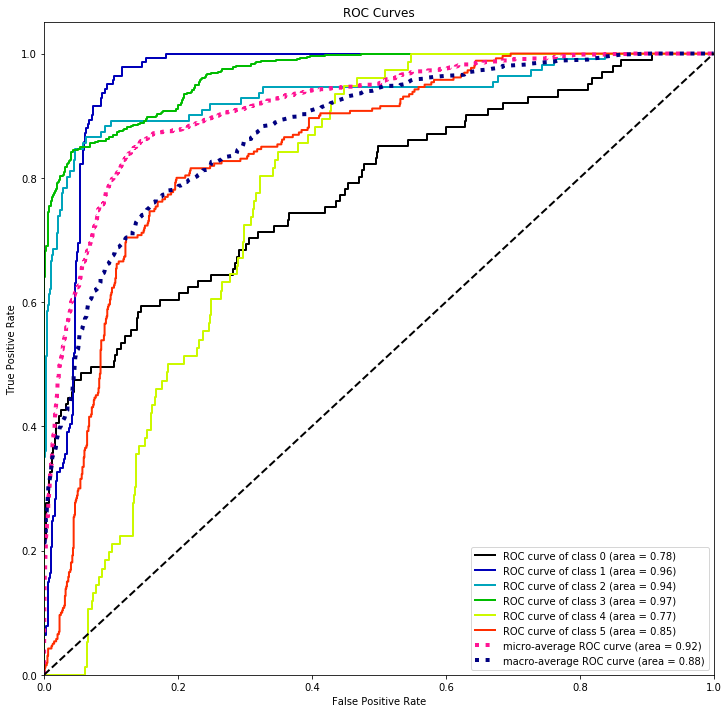

In [35]:
skplt.metrics.plot_roc(
    true_classes,
    predictions,
    figsize=(12,12))